In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from RateTraining import *
from FF_Demo import *

In [3]:
p = create_default_params_rate()
p['net_size'] = 300

In [4]:
def gen_rand_stim(p, on, off):
    N = p['net_size']
    dt = p['dt']
    timesteps = int(p['total_time']/dt)
    
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(on/dt):int(off/dt)] = rstim
    return stim

In [5]:
def gen_sine_targets(p): 
    N = p['net_size']
    dt = p['dt']
    timesteps = int(p['total_time']/dt)
    
    targets = np.zeros((N, timesteps))
    for i in range(N):
        A = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, p['total_time'], timesteps)
        targets[i] = A * np.sin(2 * np.pi * (x - t0)/t1)
    return targets

In [6]:
def gen_saw_targs(p):
    N = p['net_size']
    dt = p['dt']
    timesteps = int(p['total_time']/dt)

    targets = np.zeros((N, timesteps))
    t = np.linspace(0, p['total_time'], timesteps)
    for i in range(N):
        A = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2 * np.pi
        t1 = sp.stats.uniform.rvs() * 1000 + 500
        targets[i] = A * sp.signal.sawtooth(2 * np.pi * (t - t0)/t1, 0.5)
    
    return targets

<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
C:\Users\lab\AppData\Local\Temp\ipykernel_432\2096711694.py:24: SyntaxWarning: invalid escape sequence '\o'
  labels = ['$\omega (t)$', '$f_{in}$', '$f_{hint}$', '$f_{out}$']


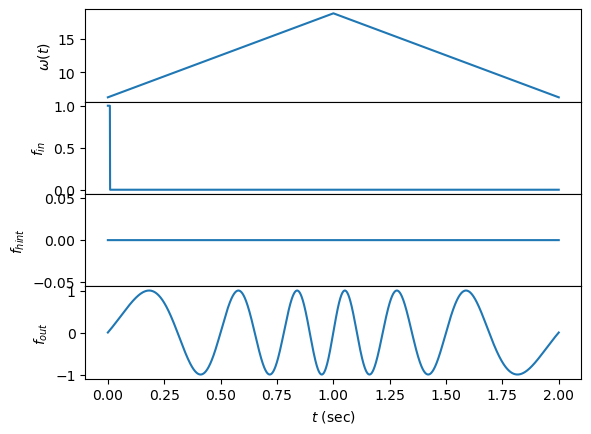

In [7]:
def inps_and_targs(dt, plot=False):
    t = np.linspace(0, 2, int(2/dt))
    
    omega = np.zeros(t.shape)
    omega[:int(t.shape[0]/2)] = np.linspace(2*np.pi, 6*np.pi, int(t.shape[0]/2))
    omega[int(t.shape[0]/2):] = np.flipud(omega[:int(t.shape[0]/2)]) # increasing decreasing (frequency of sin in fout)
    
    fout = np.zeros(t.shape)
    fout[:int(t.shape[0]/2)] = np.sin(omega[:int(t.shape[0]/2)] * t[:int(t.shape[0]/2)])
    fout[int(t.shape[0]/2):] = -np.flipud(fout[:int(t.shape[0]/2)])

    fhint = np.zeros(t.shape)

    fin = np.zeros(t.shape)
    fin[:10] = np.ones(10)

    fin = np.reshape(fin, (1, fin.size)).T
    fout = np.reshape(fout, (1, fout.size)).T
    fhint = np.reshape(fhint, (1, fhint.size)).T

    if plot:
        fig, axs = plt.subplots(4, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        labels = ['$\omega (t)$', '$f_{in}$', '$f_{hint}$', '$f_{out}$']
        for ax, y, label in zip(axs, [omega, fin, fhint, fout], labels):
            ax.plot(t, y)
            ax.set_ylabel(label)
        axs[-1].set_xlabel('$t$ (sec)')

    return (fin, fout, fhint)

dt = 0.001 
fin, fout, _ = inps_and_targs(dt, plot=True)

### fullFORCE

In [26]:
ffpar = create_parameters()
ffpar['ff_trials_per_batch'] = 100

In [27]:
fullFORCEnet = RNN(ffpar, 1, 1)

Initializing...
Training network...
Batch 1 of 10, 100 trials: 
.

c:\Users\lab\Documents\src\sam\srnn_rls\FF_Demo.py:239: RuntimeWarning: invalid value encountered in divide
  w_err_ratio = np.hstack((w_err_ratio, np.squeeze(w_err_plus/w_err)))


.................................................
..................................................
Batch 2 of 10, 100 trials: 
..................................................
..................................................
Batch 3 of 10, 100 trials: 
..................................................
..................................................
Batch 4 of 10, 100 trials: 
..................................................
..................................................
Batch 5 of 10, 100 trials: 
..................................................
..................................................
Batch 6 of 10, 100 trials: 
..................................................
..................................................
Batch 7 of 10, 100 trials: 
..................................................
..................................................
Batch 8 of 10, 100 trials: 
..................................................
........................................

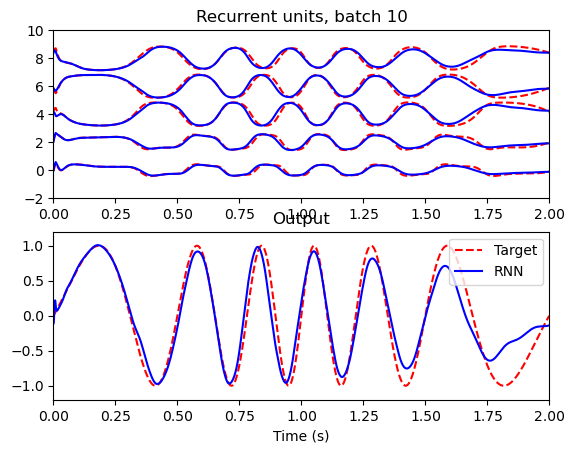

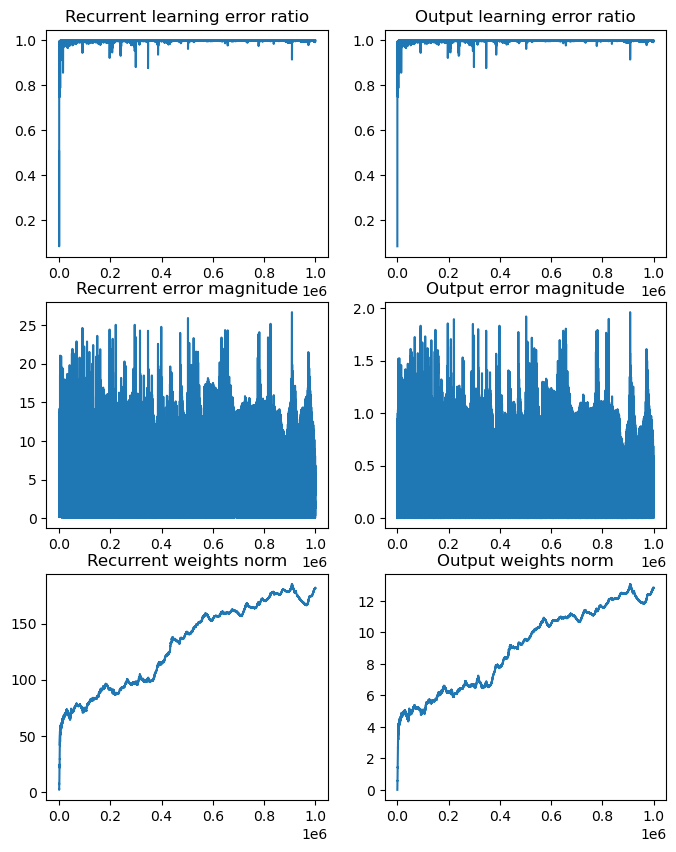

In [28]:
fullFORCEnet.train(inps_and_targs, 1)

Initializing.
Testing: 10 trials
..........
Normalized error: 2.40359


array([[2.40358733]])

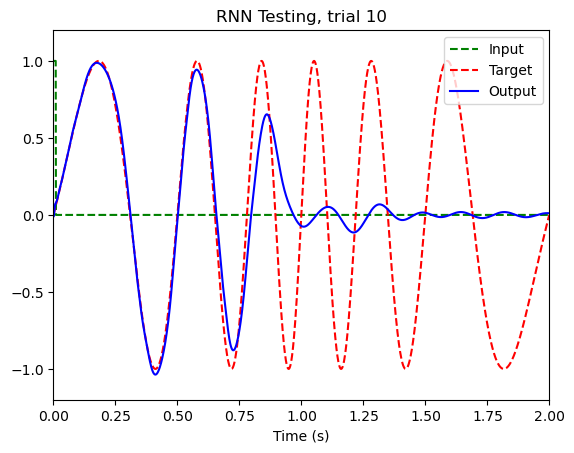

In [25]:
fullFORCEnet.test(inps_and_targs)

### fullFORCE recreation

In [28]:
pff = create_default_params_rate()
pff['training_loops'] = 100
pff['gain'] = 5

In [29]:
ffnet = RateTraining(pff)

In [30]:
ufin = ffnet.ff(fin, fout)

Initializing...
Training network...

..................................................
..................................................

In [31]:
np.shape(ufin)

(300, 2000)

In [32]:
x, Hx = ffnet.run(ufin)

Text(0.5, 1.0, 'Sample task-generating internal behavior')

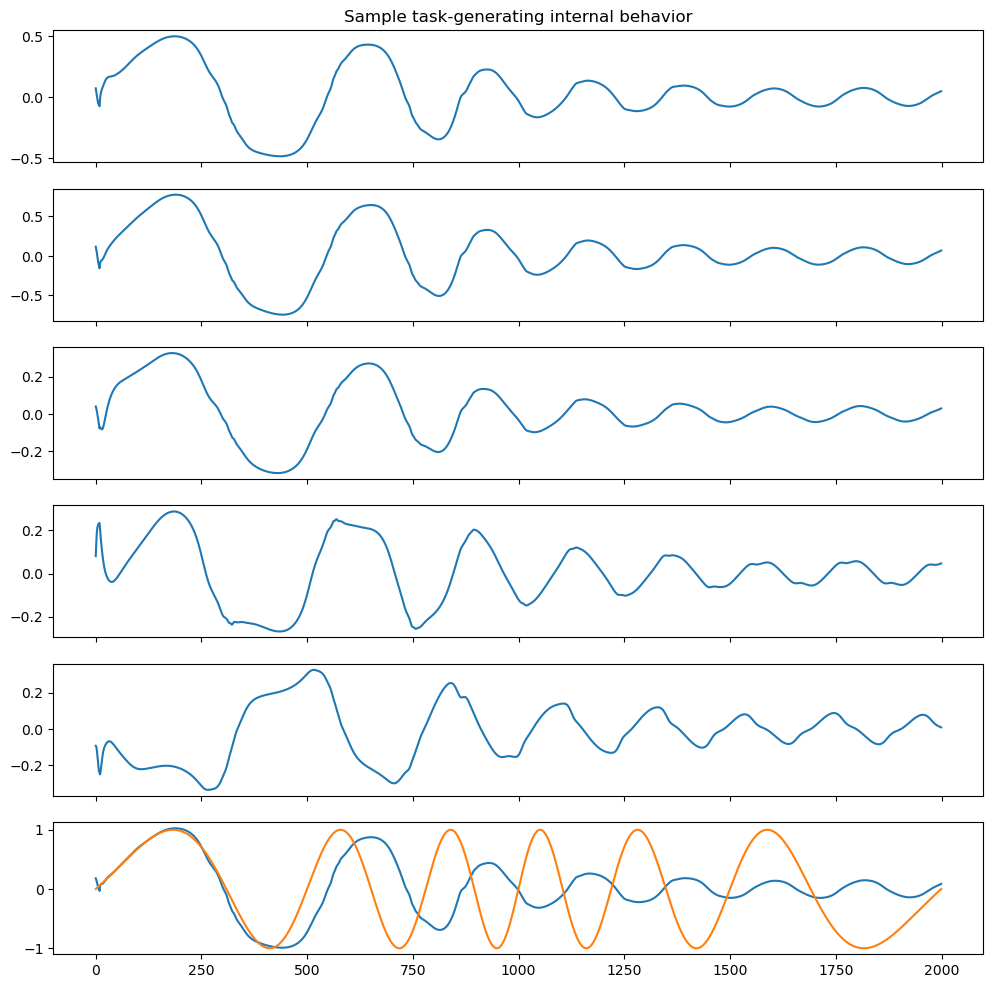

In [33]:
n_plot = 5

zt = np.dot(ffnet.W_trained, Hx)

fig, axs = plt.subplots(n_plot + 1, 1, figsize = (12, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(zt[i, :])

axs[n_plot].plot(np.squeeze(np.dot(ffnet.W_out, Hx)))
axs[n_plot].plot(fout)

axs[0].set_title("Sample task-generating internal behavior")

NameError: name 'errs' is not defined

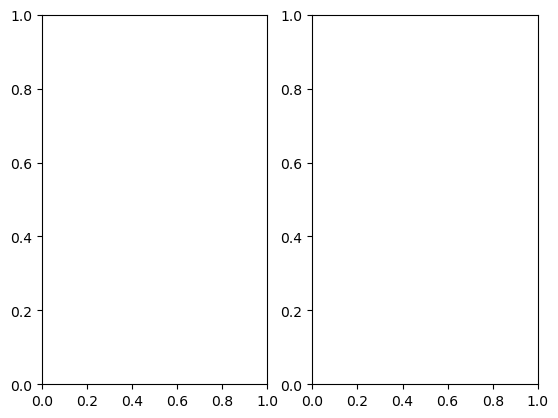

In [34]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(errs)
axs[1].plot(rel_errs)

### naive fullFORCE

In [8]:
p

{'net_size': 300,
 'num_out': 1,
 'tau_x': 10,
 'gain': 1,
 'total_time': 2000,
 'dt': 1,
 'lam': 1,
 'training_loops': 20,
 'train_every': 2,
 'm': 0,
 'std': 1,
 'cp': 1,
 'runtime': 2000}

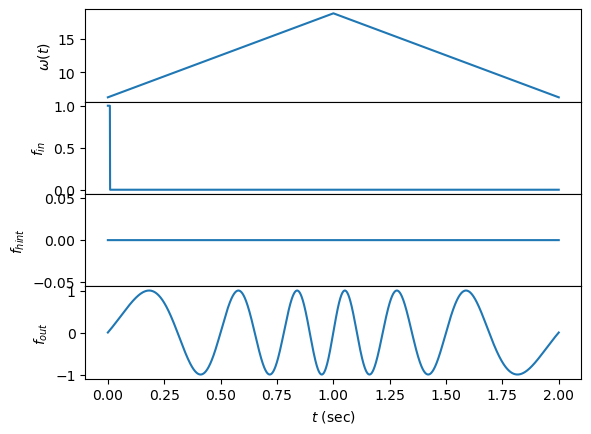

In [9]:
fin, fout, _ = inps_and_targs(dt, plot=True)

In [10]:
uin = sp.stats.uniform.rvs(size = p['net_size']) * 2 - 1
uout = sp.stats.uniform.rvs(size = p['net_size']) * 2 - 1

stim = np.outer(uin, fin)
ufout = np.outer(uout, fout)

In [11]:
dnet = RateTraining(p)

In [12]:
x, Hx = dnet.run(stim + ufout)

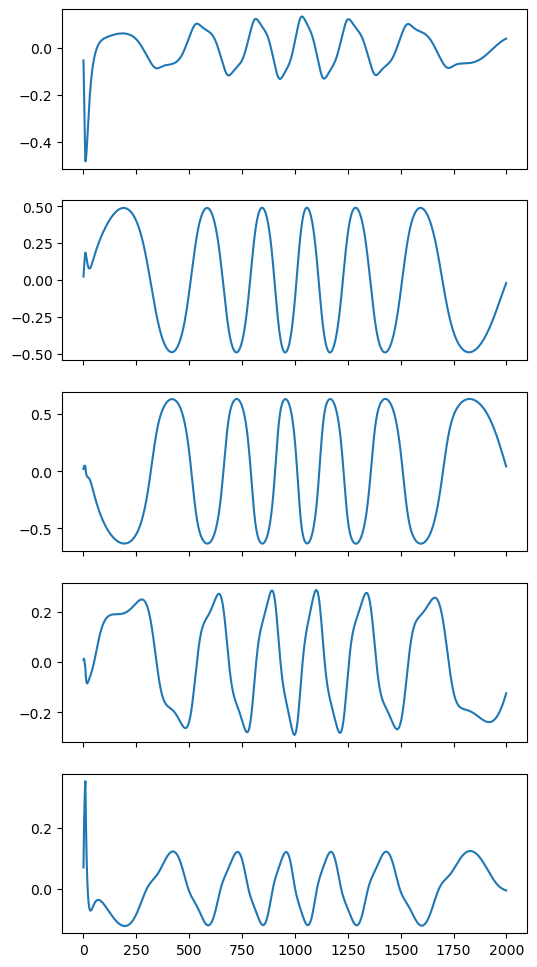

In [14]:
n_plot = 5
timesteps = int(dnet.run_time / dnet.dt)
ztdriven = dnet.W_trained @ Hx
fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(ztdriven[i])

In [17]:
tnet = RateTraining(p)
tnet.nloop = 200

In [18]:
tnet.train(stim, ztdriven + ufout, fout.T)

In [19]:
xt, Hxt = tnet.run(stim)

In [20]:
np.shape(np.squeeze(tnet.W_out @ Hxt))

(2000,)

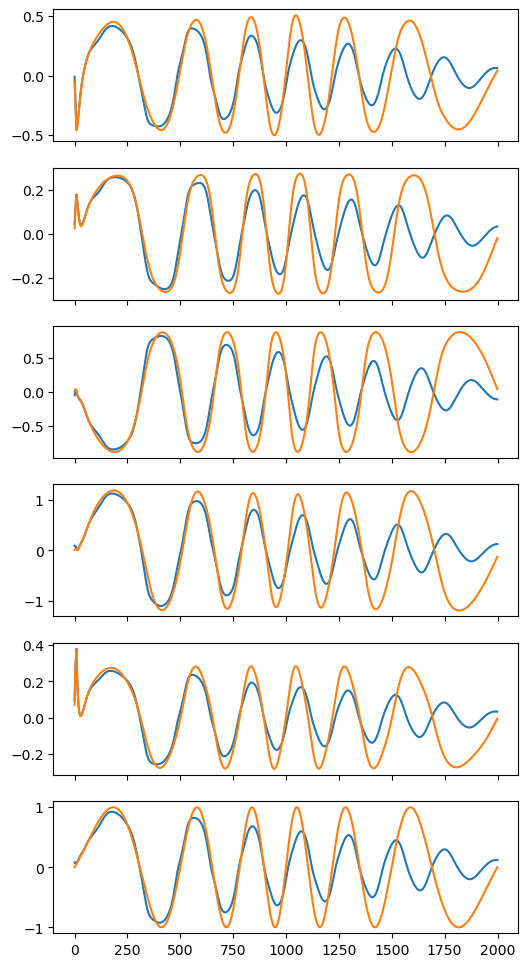

In [23]:
n_plot = 5
zt = tnet.W_trained @ Hxt

fig, axs = plt.subplots(n_plot + 1, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(zt[i])
    axs[i].plot(ztdriven[i] + ufout[i])

axs[n_plot].plot(np.squeeze(tnet.W_out @ Hxt))
axs[n_plot].plot(fout)

### normal training test

In [7]:
stargs = gen_saw_targs(p)

In [8]:
stim = gen_rand_stim(p, 0, 10)

In [9]:
targs = gen_sine_targets(p)

In [10]:
np.shape(targs)

(300, 2000)

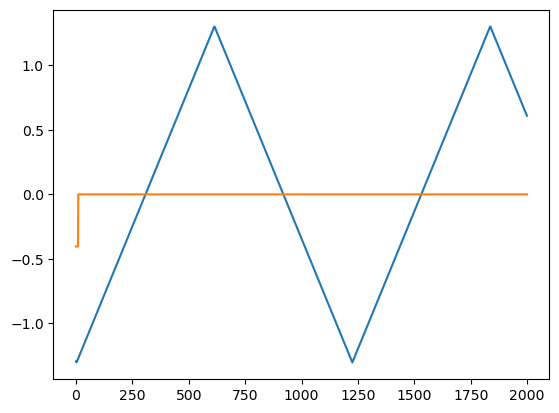

In [11]:
plt.plot(stargs[1])
plt.plot(stim[1])

In [12]:
net = RateTraining(p)
net.nloop = 100

In [13]:
net.train(stim, stargs, np.zeros((net.N, int(net.T/net.dt))))

In [14]:
xr, hxr = net.run(stim)

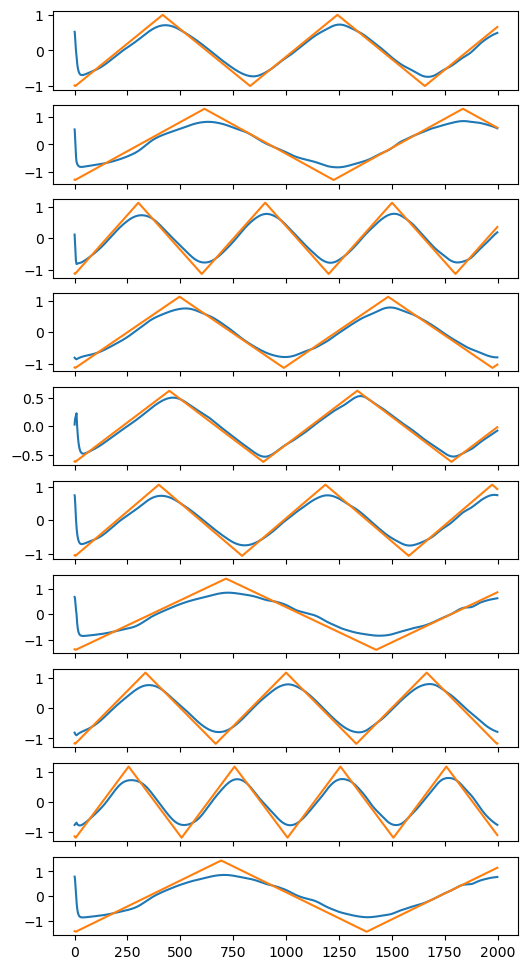

In [15]:
n_plot = 10
nloop = net.nloop
timesteps = int(net.run_time / net.dt)

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(hxr[i])
    axs[i].plot(stargs[i])
    #axs[i].plot(stim[i])

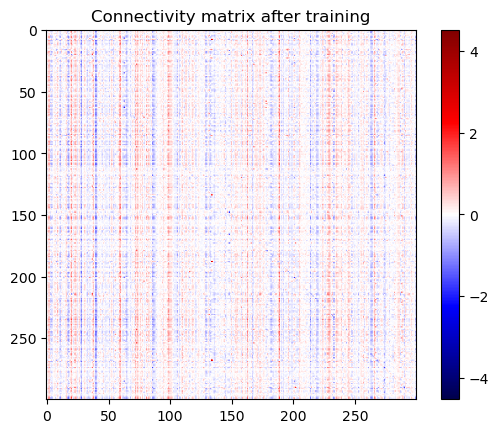

In [16]:
m = max(-1*np.min(net.W_trained), np.max(net.W_trained))

plt.imshow(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


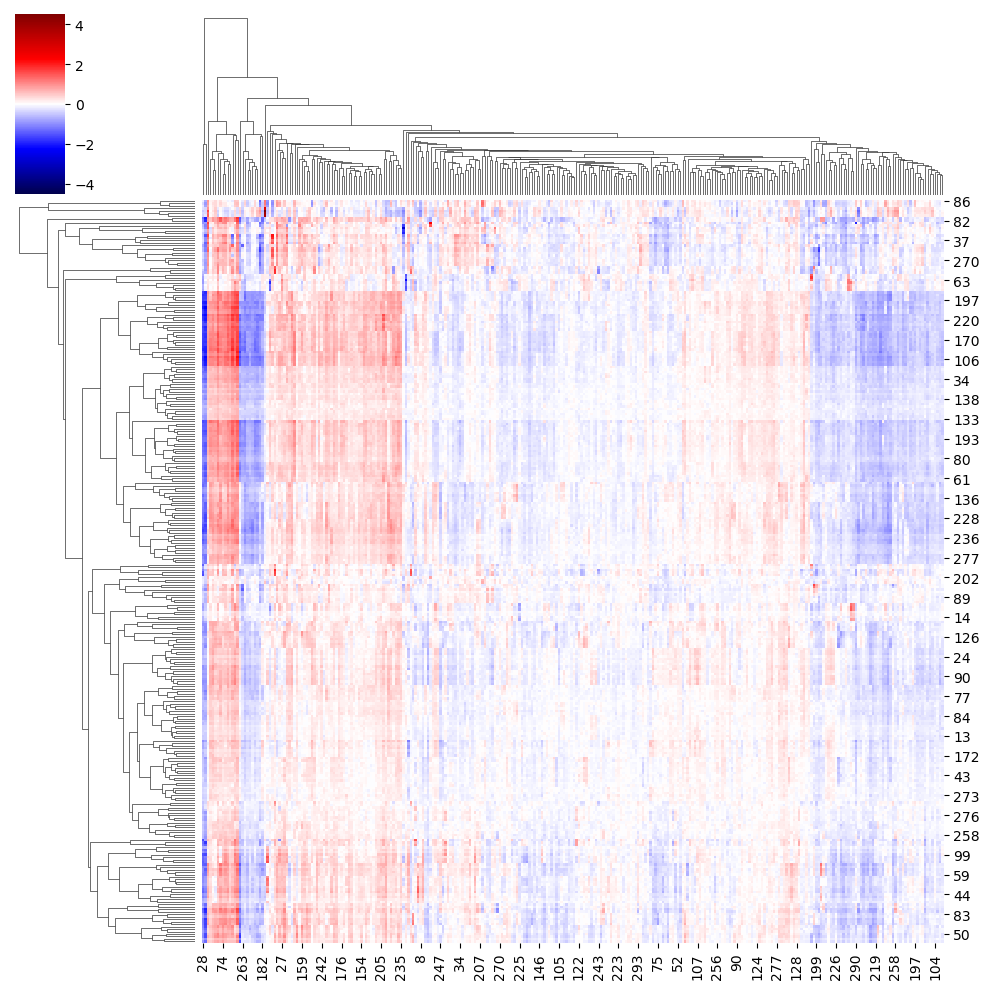

In [17]:
sns.clustermap(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)